# 0-π oscillations in altermagnetic Josephson junctions

## Common imports


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from bodge import *


Bad key "text.kerning_factor" on line 4 in
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Lattice construction
These functions take lattice coordinates $i, j ∈ \mathbb{N}^3$ as inputs, and for a given junction type (0º or 45º interfaces) determines whether a region is superconducting, normal metallic, or altermagnetic. Note that these functions depend on some global variables like `DIAG` and `L_SC`, which are used to alter the properties of the junctions investigated below. These variables are declared here but updated below.

In [2]:
# Whether the system has a diagonal interface.
DIAG = False

# Dimensions of the cubic lattice.
L_X = 0
L_Y = 0
L_Z = 0

# Superconductor length.
L_SC = 0 

# Normal-metal spacer length.
L_NM = 0

# Interlayer length. This can be an altermagnet.
L_IL = 0

This function calculates an "equivalent x-coordinate" for junctions with diagonal interfaces, defined as the x-coordinate at the center along the y-axis.

In [3]:
def diax(i):
    return i[0] + (i[1] - L_Y//2) * DIAG

These functions check whether a coordinate is superconducting, normal metallic, or altermagnetic.

In [4]:
def SC1(i):
    return diax(i) < L_SC
    
def SC2(i):
    return diax(i) >= L_X - L_SC

def NM1(i):
    return diax(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return diax(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

These functions let us calculate the y-integrated current in the middle of the first normal-metal layer, which we will use as a measure for the supercurrent. We calculate the current at $T = 0.01t$ for now.

In [5]:
def probe(i):
    return diax(i) == L_SC + L_NM//2

def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    J = F.current_elec(axis=0)

    return sum(J[i] for i in lattice.sites() if probe(i))

We can also define a function for visualizing the lattices, to reduce the chance of errors. The evaluation point for currents is plotted in red.

In [6]:
def show():
    lattice = CubicLattice((L_X, L_Y, L_Z))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i in lattice.sites():
        if SC1(i) or SC2(i):
            ax.scatter(x=i[0], y=i[1], color='#ff7f00')
        if NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k')
        if IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3')
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000')

    plt.show()

Let's test that these work as expected by plotting one diagonal and one non-diagonal lattice.

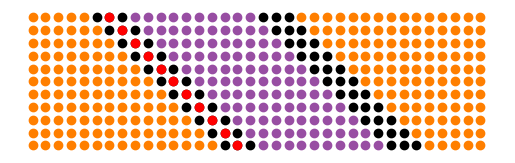

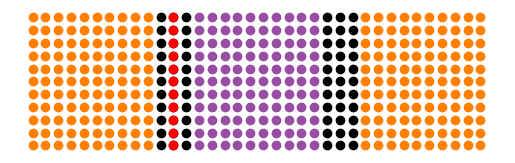

In [7]:
L_SC = 10 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

show()

DIAG = False

show()

## Normal-metal baseline


For comparison to the altermagnetic case, let's do a quick run on normal metals (which have no 0-π oscillations). Based on separate benchmarks of the Chebyshev code, we should use 600 polynomials at least for explorative current calculations and perhaps 2000 for final ones.

First, let's define the tight-binding parameters:

In [9]:
t = 1.0
μ = -t/2
Δ0 = -t
δφ = π/2

  0%|          | 0/15 [00:00<?, ?it/s]

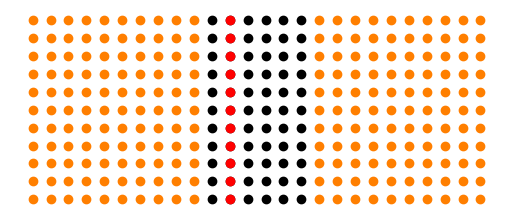





  7%|▋         | 1/15 [00:04<00:56,  4.01s/it]

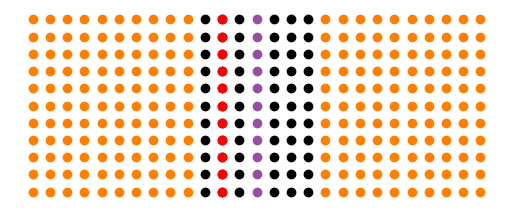





 13%|█▎        | 2/15 [00:08<00:55,  4.24s/it]

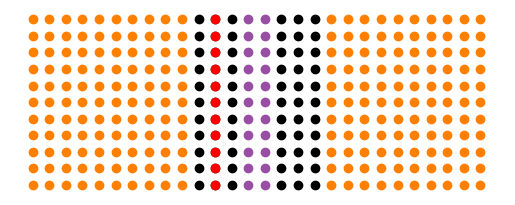





 20%|██        | 3/15 [00:13<00:53,  4.42s/it]

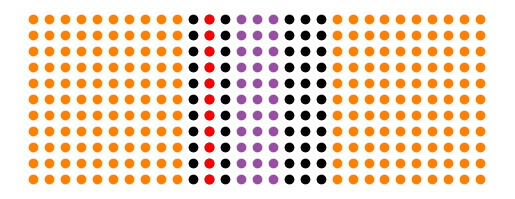





 27%|██▋       | 4/15 [00:17<00:50,  4.57s/it]

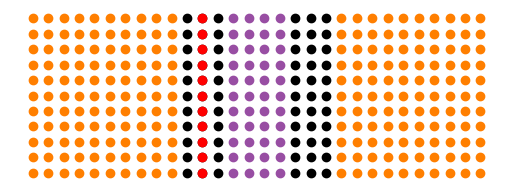





 33%|███▎      | 5/15 [00:23<00:48,  4.80s/it]

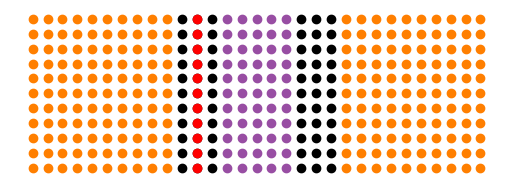





 40%|████      | 6/15 [00:28<00:45,  5.03s/it]

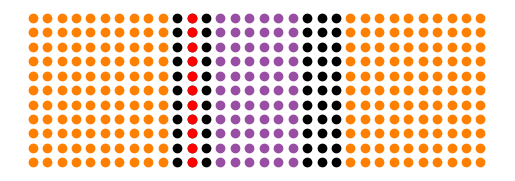





 47%|████▋     | 7/15 [00:34<00:42,  5.28s/it]

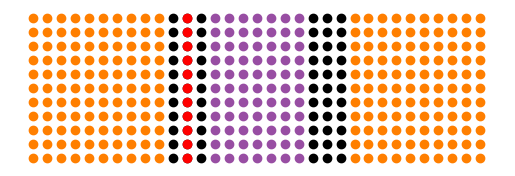





 53%|█████▎    | 8/15 [00:40<00:39,  5.59s/it]

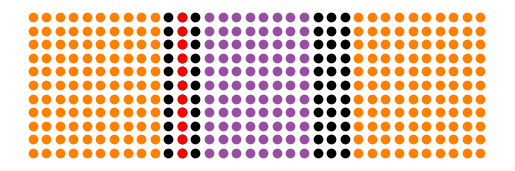





 60%|██████    | 9/15 [00:47<00:35,  5.85s/it]

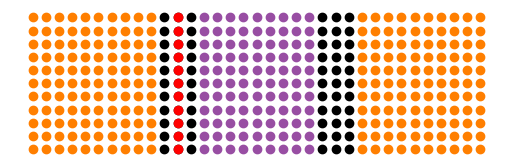





 67%|██████▋   | 10/15 [00:53<00:30,  6.13s/it]

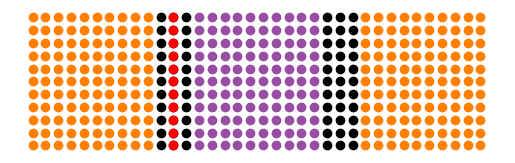





 73%|███████▎  | 11/15 [01:01<00:25,  6.48s/it]

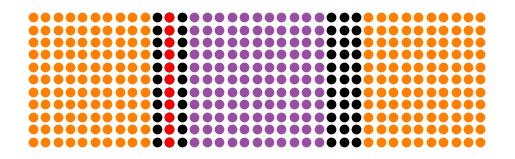





 80%|████████  | 12/15 [01:08<00:20,  6.78s/it]

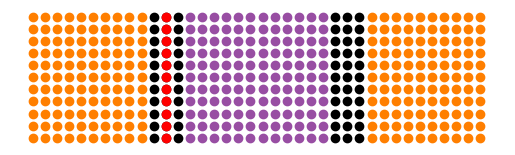





 87%|████████▋ | 13/15 [01:16<00:14,  7.12s/it]

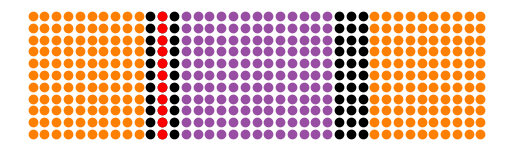





 93%|█████████▎| 14/15 [01:24<00:07,  7.46s/it]

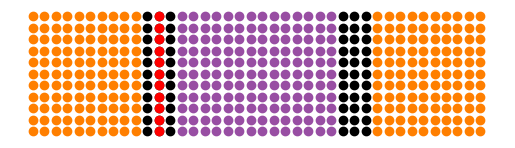





  0%|          | 0/15 [00:00<?, ?it/s]

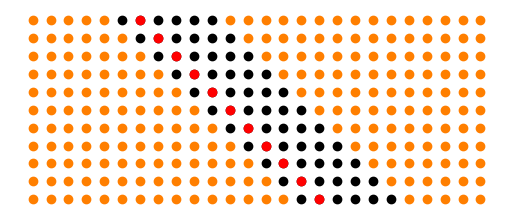





  7%|▋         | 1/15 [00:04<00:56,  4.07s/it]

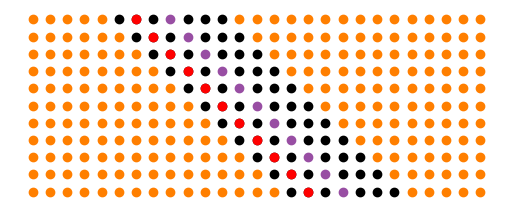





 13%|█▎        | 2/15 [00:08<00:54,  4.21s/it]

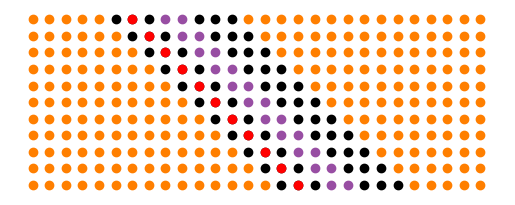





 20%|██        | 3/15 [00:13<00:53,  4.42s/it]

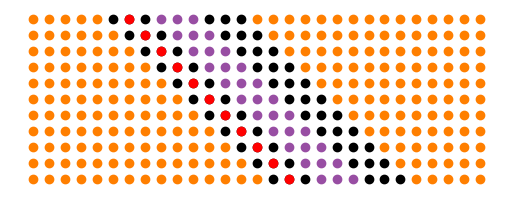





 27%|██▋       | 4/15 [00:17<00:50,  4.61s/it]

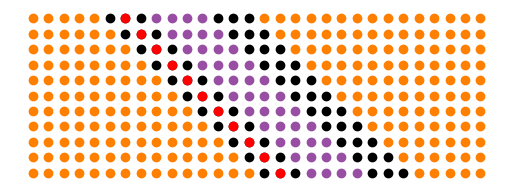





 33%|███▎      | 5/15 [00:23<00:48,  4.82s/it]

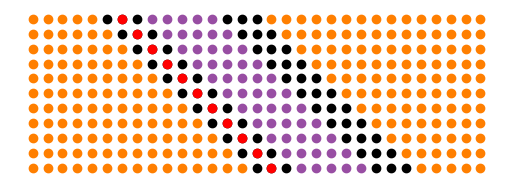





 40%|████      | 6/15 [00:28<00:45,  5.07s/it]

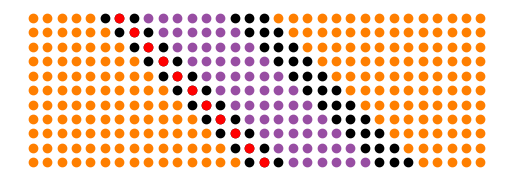





 47%|████▋     | 7/15 [00:34<00:42,  5.31s/it]

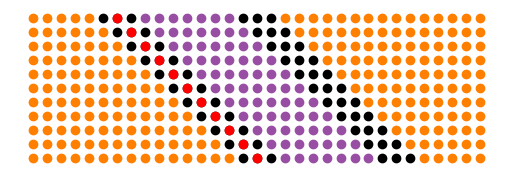





 53%|█████▎    | 8/15 [00:40<00:39,  5.59s/it]

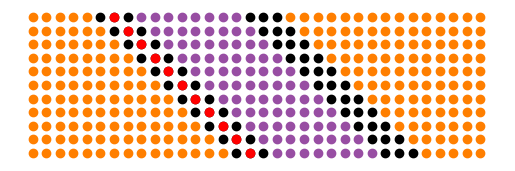





 60%|██████    | 9/15 [00:47<00:35,  5.90s/it]

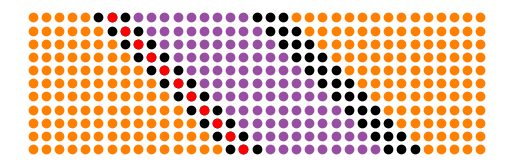





 67%|██████▋   | 10/15 [00:54<00:30,  6.19s/it]

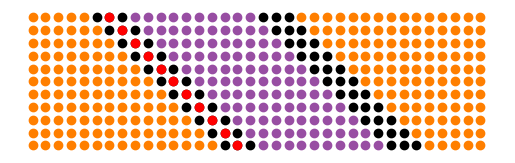





 73%|███████▎  | 11/15 [01:01<00:25,  6.49s/it]

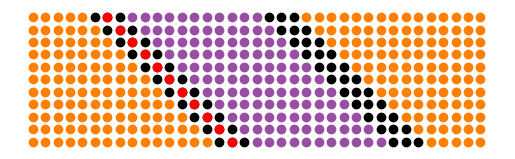





 80%|████████  | 12/15 [01:08<00:20,  6.81s/it]

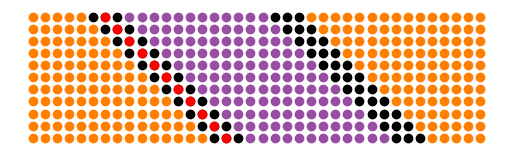





 87%|████████▋ | 13/15 [01:16<00:14,  7.11s/it]

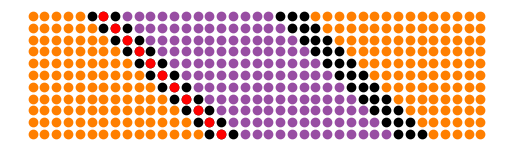





 93%|█████████▎| 14/15 [01:24<00:07,  7.48s/it]

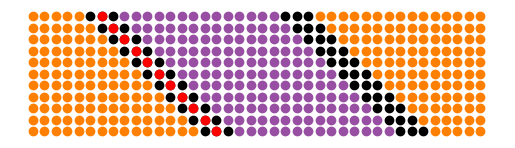





100%|██████████| 15/15 [01:33<00:00,  6.24s/it]


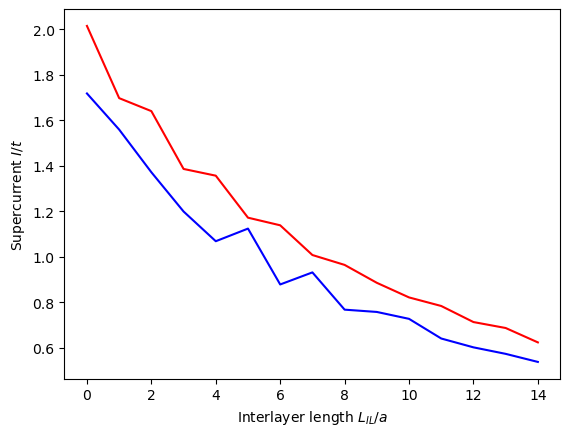

In [16]:
LL = []
JJ = []

for DIAG in [False, True]:
    Ls = []
    Js = []

    for L_IL in trange(15):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "b", LL[1], JJ[1], "r")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

This shows a qualitatively similar behavior for S/N/S junctions with the two different types of interfaces, although the curves quantitatively differ by perhaps 10% or so.

## Ferromagnetic baseline

Let's now try to use a ferromagnetic interlayer and repeat the experiment above. The point is to show that we can get 0-π oscillations for both types of interfaces, as a comparison for the altermagnets.

In [19]:
m = 3 * t / 2

  0%|          | 0/20 [00:00<?, ?it/s]

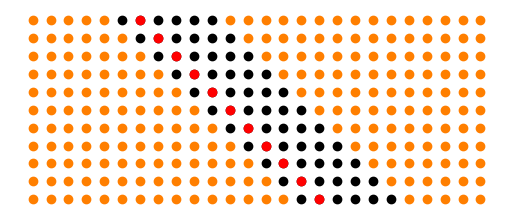

  5%|▌         | 1/20 [00:04<01:17,  4.06s/it]

	J/t = 2.015465791683232


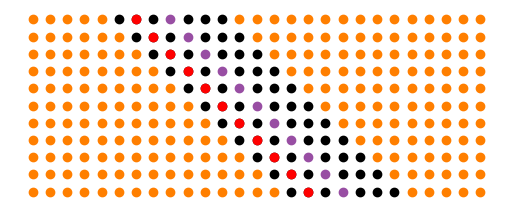

 10%|█         | 2/20 [00:08<01:15,  4.22s/it]

	J/t = 1.332384691192438


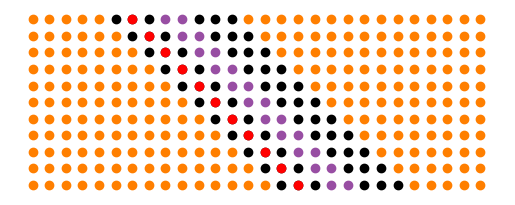

 15%|█▌        | 3/20 [00:13<01:16,  4.48s/it]

	J/t = -0.2604906673832356


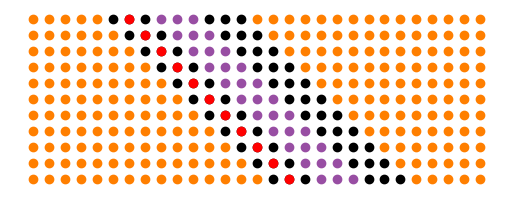

 20%|██        | 4/20 [00:18<01:14,  4.65s/it]

	J/t = -1.0871413058541979


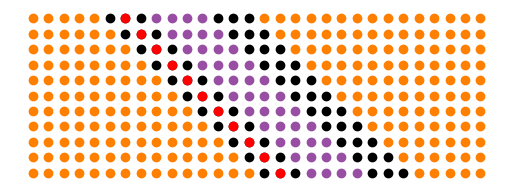

 25%|██▌       | 5/20 [00:23<01:12,  4.84s/it]

	J/t = -0.8179578986171852


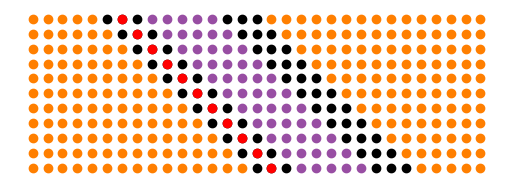

 30%|███       | 6/20 [00:28<01:11,  5.10s/it]

	J/t = -0.3724201533784677


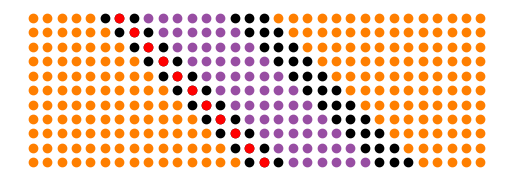

 35%|███▌      | 7/20 [00:34<01:09,  5.37s/it]

	J/t = 0.20315763463331746


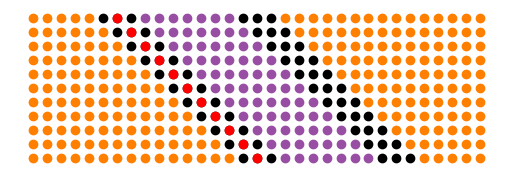

 40%|████      | 8/20 [00:40<01:07,  5.63s/it]

	J/t = 0.5696154150738635


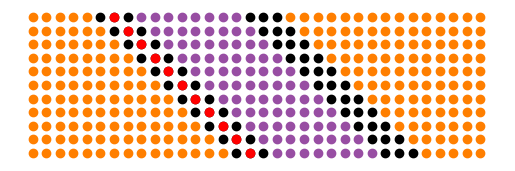

 45%|████▌     | 9/20 [00:47<01:05,  5.92s/it]

	J/t = 0.4652356711507934


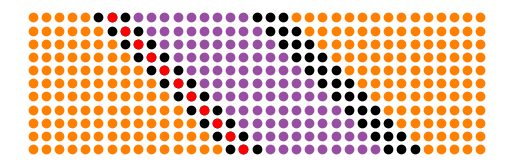

 50%|█████     | 10/20 [00:54<01:02,  6.21s/it]

	J/t = 0.15414503316188527


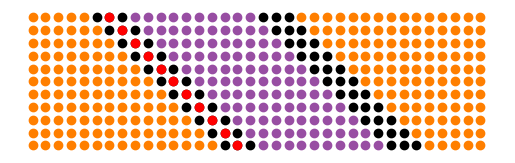

 55%|█████▌    | 11/20 [01:01<00:58,  6.53s/it]

	J/t = -0.1884807164636324


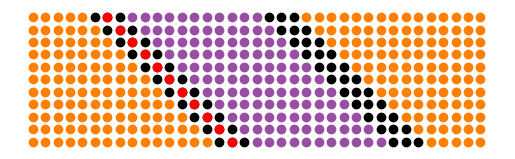

 60%|██████    | 12/20 [01:09<00:54,  6.84s/it]

	J/t = -0.3422853945949927


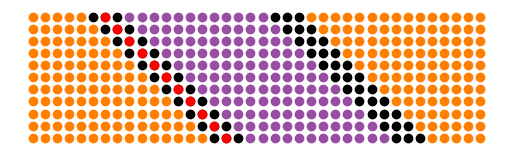

 65%|██████▌   | 13/20 [01:17<00:50,  7.17s/it]

	J/t = -0.24598030130064977


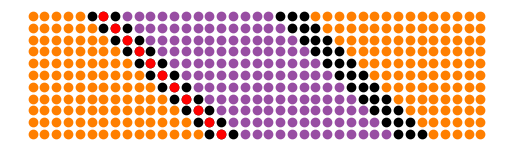

 70%|███████   | 14/20 [01:25<00:44,  7.41s/it]

	J/t = -0.0850640800186751


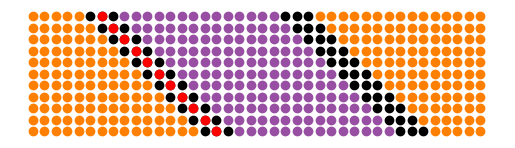

 75%|███████▌  | 15/20 [01:33<00:39,  7.80s/it]

	J/t = 0.10191323927409884


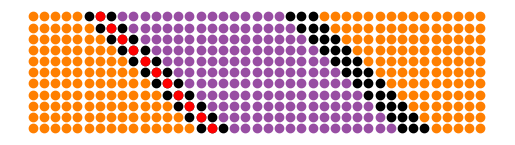

 80%|████████  | 16/20 [01:42<00:32,  8.17s/it]

	J/t = 0.17620223775657387


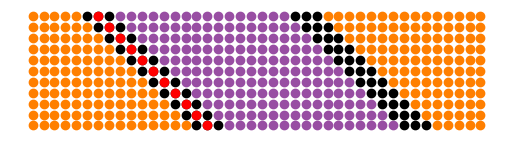

 85%|████████▌ | 17/20 [01:52<00:25,  8.59s/it]

	J/t = 0.1276724816218928


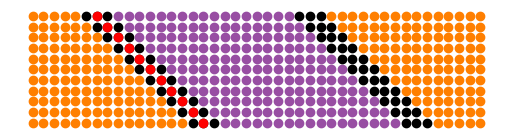

 90%|█████████ | 18/20 [02:02<00:17,  8.95s/it]

	J/t = 0.06390719498349134


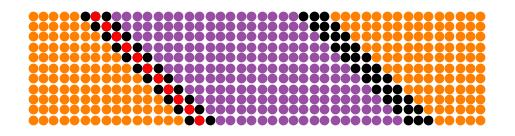

 95%|█████████▌| 19/20 [02:12<00:09,  9.34s/it]

	J/t = -0.016282503616389794


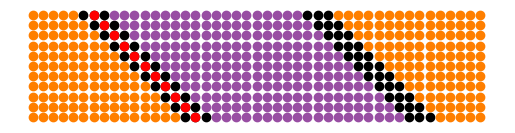

100%|██████████| 20/20 [02:23<00:00,  7.16s/it]


	J/t = -0.07390771842277877


  0%|          | 0/20 [00:00<?, ?it/s]

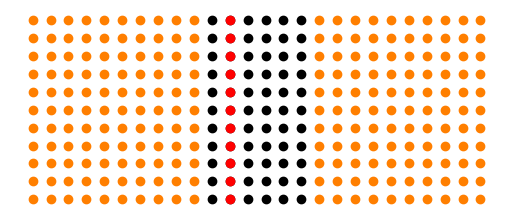

  5%|▌         | 1/20 [00:04<01:16,  4.02s/it]

	J/t = 1.718350173392475


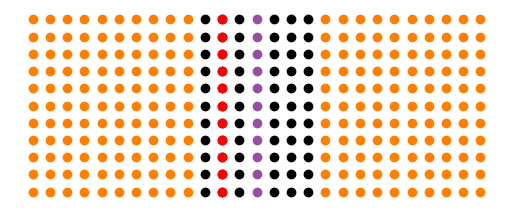

 10%|█         | 2/20 [00:08<01:16,  4.27s/it]

	J/t = 0.21368022807017908


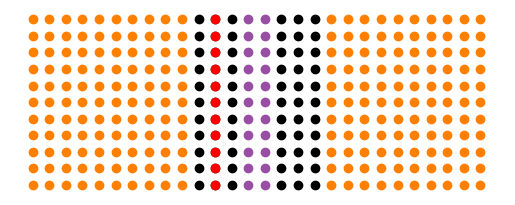

 15%|█▌        | 3/20 [00:13<01:15,  4.42s/it]

	J/t = -0.7548923949285613


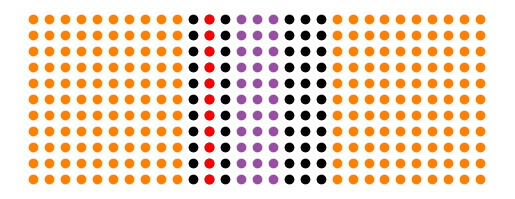

 20%|██        | 4/20 [00:18<01:14,  4.63s/it]

	J/t = 0.11859098275351548


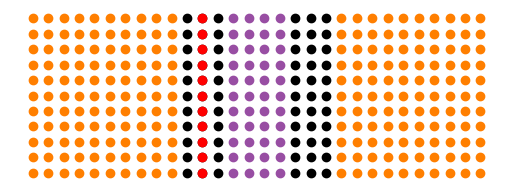

 25%|██▌       | 5/20 [00:23<01:13,  4.89s/it]

	J/t = 0.24045893393485485


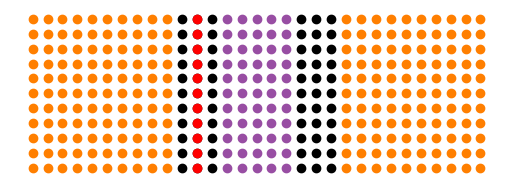

 30%|███       | 6/20 [00:28<01:11,  5.11s/it]

	J/t = -0.17073417275018396


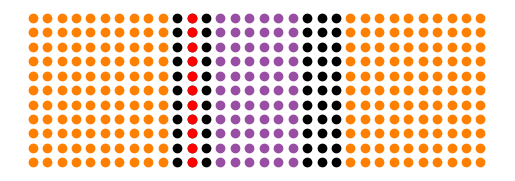

 35%|███▌      | 7/20 [00:34<01:09,  5.36s/it]

	J/t = -0.11132901000496105


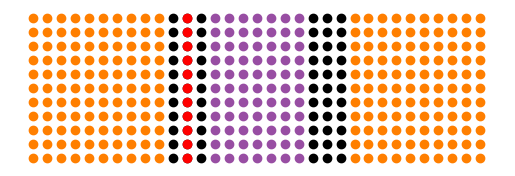

 40%|████      | 8/20 [00:40<01:07,  5.61s/it]

	J/t = 0.07654988729142254


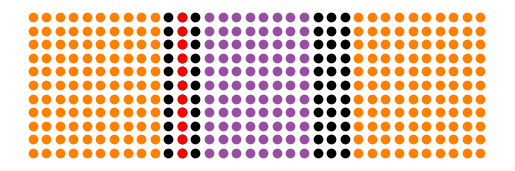

 45%|████▌     | 9/20 [00:47<01:05,  5.91s/it]

	J/t = 0.00653851360264462


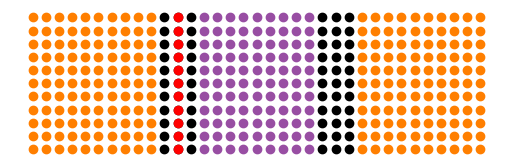

 50%|█████     | 10/20 [00:54<01:01,  6.18s/it]

	J/t = -0.07142697677262135


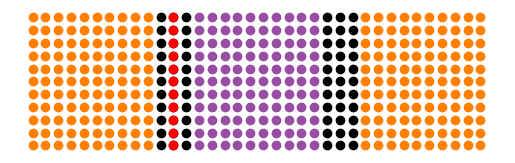

 55%|█████▌    | 11/20 [01:01<00:58,  6.47s/it]

	J/t = -0.028113097605302555


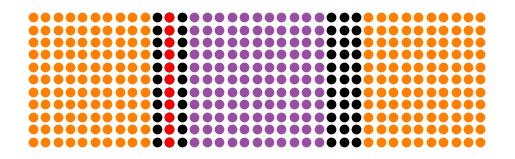

 60%|██████    | 12/20 [01:08<00:54,  6.80s/it]

	J/t = 0.017162680447243298


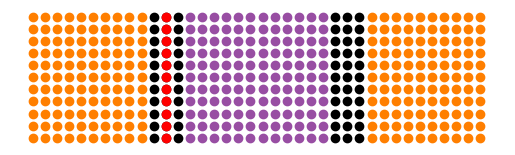

 65%|██████▌   | 13/20 [01:16<00:49,  7.12s/it]

	J/t = 0.010436069183513296


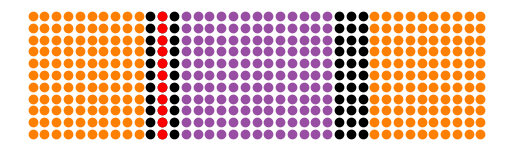

 70%|███████   | 14/20 [01:25<00:44,  7.47s/it]

	J/t = -0.024766409296918646


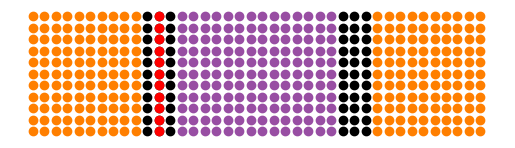

 75%|███████▌  | 15/20 [01:33<00:38,  7.79s/it]

	J/t = -0.0217900505595068


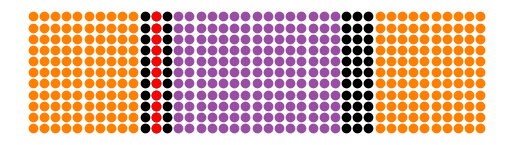

 80%|████████  | 16/20 [01:42<00:32,  8.20s/it]

	J/t = 0.021022574207454528


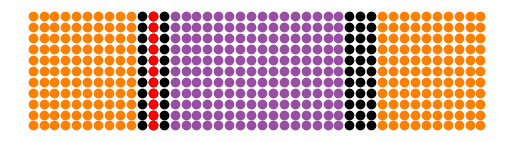

 85%|████████▌ | 17/20 [01:52<00:25,  8.58s/it]

	J/t = 0.015119206786283295


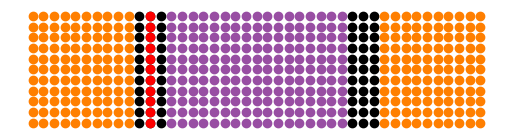

 90%|█████████ | 18/20 [02:02<00:17,  8.99s/it]

	J/t = -0.025186022269187983


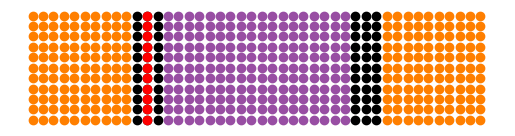

 95%|█████████▌| 19/20 [02:12<00:09,  9.35s/it]

	J/t = -0.007891914935838958


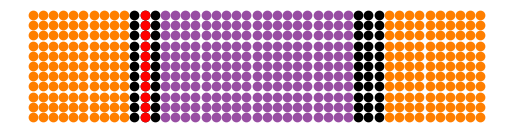

100%|██████████| 20/20 [02:23<00:00,  7.16s/it]

	J/t = 0.025825215439378824


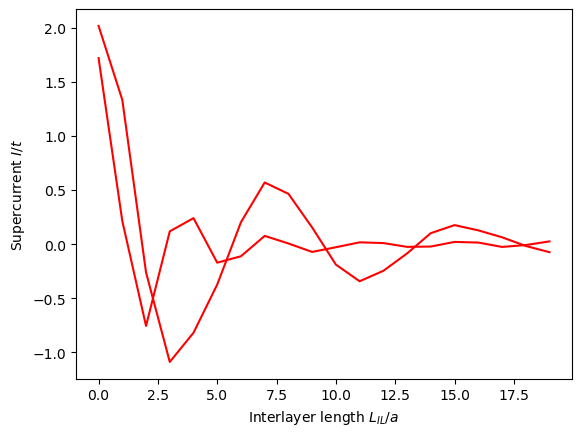

In [20]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(20):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if IL(i):
                    H[i, i] = -μ * σ0 - m * σ3
                else:
                    H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

Clearly, the interface type changes the period drastically, but 0-π oscillations occurs for both.

## Altermagnetic test for δφ = π/2


  0%|          | 0/5 [00:00<?, ?it/s]

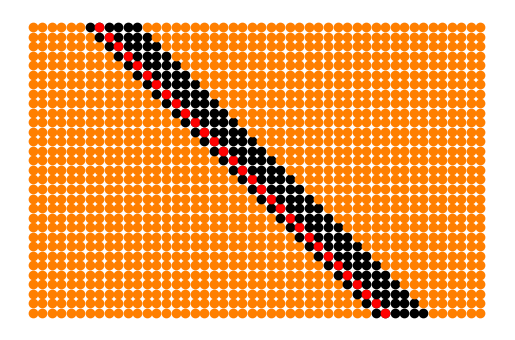

In [27]:
m = 1.5 * t
L_SC = 21
L_Y = 31

LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(5):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0
    
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()